# 説明
## 目的：
1枚の画像の半分(一部)を切り取ったものを入力とし、元の全体の画像を出力させる。

必要なLibraryをImportする。  
※tensorflowは2.3を使っています。

In [1]:
import tensorflow as tf
assert tf.__version__.startswith('2')

In [2]:
import os
import time
import numpy as np
import cv2

同じ結果を再現できるように、各LibraryのSEEDをセットする。

In [3]:
np.random.seed(222)
tf.random.set_seed(222)

定数を定義する。

In [4]:
# Define constance
batch_size = 128
shuffle_size = 10000

## データを準備する。
・利用されたデータセット：mnist
元のデータは28*28*1の画像ですが、Upsamplingで画像を再現できるように32*32*1にResizeしました。  
※画像サイズが28の場合：
　Encoder:28→DownSampling→14→DownSampling→7→DownSampling→4   
　Decoder:32← UpSampling ←16← UpSampling ←8← UpSampling ←4  
サイズが一致になってないのため、32にResizeすると：  
　Encoder:32→DownSampling→16→DownSampling→8→DownSampling→4   
　Decoder:32← UpSampling ←16← UpSampling ←8← UpSampling ←4  
・Resize：28→32にResizeすると、(32-28)/2=2なので、各方向をpaddingを2に設定する。(0でPad)

In [5]:
# Prepare data
(x_train_, y_train_), (x_test_, y_test_) = tf.keras.datasets.mnist.load_data()

## Resize data
paddings = tf.constant([[0,0],[2,2],[2,2]])
x_train_ = tf.pad(x_train_, paddings)
x_test_ = tf.pad(x_test_, paddings)

x_train_ = tf.expand_dims(x_train_, 3)
x_test_ = tf.expand_dims(x_test_, 3)

## Range(-1, 1)
x_train = x_train_.numpy().astype(np.float32)/127.5 - 1
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(shuffle_size).batch(batch_size)

x_test = x_test_.numpy().astype(np.float32)/127.5 - 1
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

print(x_train_.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 32, 32, 1)


# Utils

画像の上の半分を取り出して、入力として使われてます。

In [6]:
def img_crop(inputs):
    new_imgs = np.zeros_like(inputs) - np.ones_like(inputs)
    new_imgs[:,0:16,:,:] = inputs.numpy()[:,0:16,:,:]
    return new_imgs

# Build the Generator
- Down-Sample：Conv2D(stride=2)により、DownSampleを実施  
　DownSampleのBlockの構成：  
　Conv2D→BN(optional)→LeakyRelu(入力データが[-1,1]のため)  
- Up-Sample：Conv2DTransposeにより、UpSampleを実施
　UpSampleのBlockの構成：  
　Conv2D→BN(optional)→Dropout→LeakyRelu  
- generaor: u-net
- Generator loss = binaryCrossEntropy + L1

In [7]:
# DownSample -> Conv2.strides=2 -> half
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [8]:
# Upsample -> Conv2DTranspose.strides=2 -> double
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                       padding='same',
                                       kernel_initializer=initializer,
                                       use_bias = False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

Generator基本構成：U-Net

In [9]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (b, 16, 16, 64)
        downsample(128, 4),                        # (b, 8, 8, 128)
        downsample(256, 4),                        # (b, 4, 4, 256)
        downsample(512, 4),                        # (b, 2, 2, 512)
        downsample(512, 4)                         # (b, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (b, 2, 2, 512)
        upsample(256, 4, apply_dropout=True), # (b, 4, 4, 256)
        upsample(128, 4),                     # (b, 8, 8, 256)
        upsample( 64, 4)                      # (b, 16, 16, 256)
    ]
                 
    initialier = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                          kernel_initializer=initialier,
                                          activation='tanh')
    
    x = inputs
    
    # Down sampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Up sampling and establishing the skip connection
    for up, skip in zip(up_stack, skips):
        x=up(x)
        x= tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
generator = Generator()

In [11]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Generator loss = binaryCrossEntropy + L1

In [12]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    loss = gan_loss + (LAMBDA*l1_loss)
    
    return loss, gan_loss, l1_loss

# Build the discriminator
- PatchGAN

元論文のPatchGANは最後の出力は30*30になっていて、各Pixel視野は70になっていますが、今回使用したデータセットは簡単で、元画像が28*28しかないので、最後の出力は4*4のように設定しています。

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    
    inputs = tf.keras.layers.Input(shape=[32,32,1], name='input_image')
    target = tf.keras.layers.Input(shape=[32,32,1], name='target_image')
    
    x = tf.keras.layers.concatenate([inputs, target]) #b,32,32,c*2
    
    down1 = downsample(64, 4, False)(x) # b, 16, 16, 64
    down2 = downsample(128, 4)(down1)   # b, 8, 8, 128
    down3 = downsample(256, 4)(down2)   # b, 4, 4, 256
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                kernel_initializer=initializer)(down3) # (bs, 4, 4, 1)

    return tf.keras.Model(inputs=[inputs, target], outputs=last)

In [14]:
discriminator = Discriminator()

In [15]:
def discriminator_loss(disc_real_output, disc_gen_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)
    
    loss = real_loss + gen_loss
    
    return loss

# Define the Optimizers

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Save Result

In [17]:
def save_result(model, target, name):
    bs = target.shape[0]
    idx = np.random.choice(bs, 1)
    
    tar = target[idx[0],...]
    tar = tar[np.newaxis,...]
    test_input = img_crop(tar)
        
    prediction = model(test_input)
    new_img = np.zeros((32, 32*3))
    
    new_img[0:32,0:32] = test_input[0,...,0]
    new_img[0:32,32:64] = tar.numpy()[0,...,0]
    new_img[0:32,64:96] = prediction.numpy()[0,...,0]
   
    new_img = np.clip(new_img*127.5 + 127.5, 0, 255)
    new_img.astype(np.uint8)
    
    cv2.imwrite(name, new_img)

# Traing

In [18]:
EPOCHS = 4
loss_gen_all = []
loss_l1 = []
loss_gen = []
loss_disc = []

In [19]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    # Save loss to plot later
    loss_gen.append(gen_gan_loss.numpy())
    loss_l1.append(gen_l1_loss.numpy())
    loss_gen_all.append(gen_total_loss.numpy())
    loss_disc.append(disc_loss.numpy())

In [20]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        for step, target in enumerate(train_ds):
            input_image = img_crop(target)
            train_step(input_image, target, epoch)
            if step%100 == 0:
                print("Epoch%d -> %d"%(epoch,step))
                #print("GenLoss: %.2f DiscLoss %.2f"%(tf.make_loss_gen[-1].numpy(),loss_disc[-1].numpy()))
                x = next(iter(test_ds))
                save_result(generator, x, "result_%d_%d.jpg"%(epoch, step))

        # saving result for every epoch
        #if (epoch + 1) % 1 == 0:
        #    x = next(iter(test_ds))
        #    save_result(generator, x, "result_%d.jpg"%epoch)

In [21]:
fit(x_train, EPOCHS, x_test)

Epoch0 -> 0
Epoch0 -> 100
Epoch0 -> 200
Epoch0 -> 300
Epoch0 -> 400
Epoch1 -> 0
Epoch1 -> 100
Epoch1 -> 200
Epoch1 -> 300
Epoch1 -> 400
Epoch2 -> 0
Epoch2 -> 100
Epoch2 -> 200
Epoch2 -> 300
Epoch2 -> 400
Epoch3 -> 0
Epoch3 -> 100
Epoch3 -> 200
Epoch3 -> 300
Epoch3 -> 400


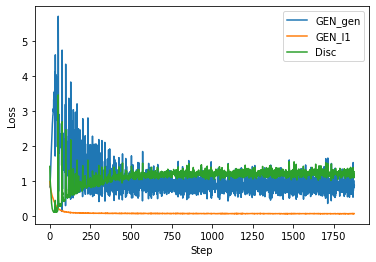

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_gen)), loss_gen)
plt.plot(range(len(loss_l1)), loss_l1)
plt.plot(range(len(loss_disc)), loss_disc)
plt.legend(["GEN_gen", "GEN_l1", "Disc"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

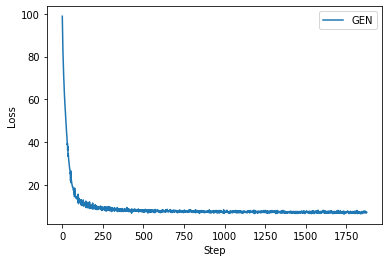

In [23]:
plt.plot(range(len(loss_gen_all)), loss_gen_all)
plt.legend(["GEN"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

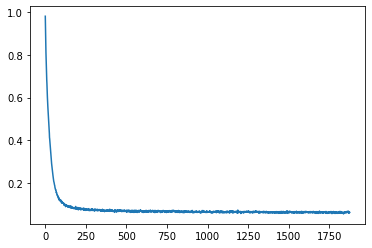

In [24]:
plt.plot(range(len(loss_l1)), loss_l1)
plt.show()